In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import os

from scipy.spatial.distance import pdist
from scipy import linalg

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

## Data Import

In [4]:
data = pd.read_csv("Iris_Mythica_Data_Set.csv")
data

,Index,sepal.length,sepal.width,petal.length,petal.width,class
0,1,5.10,3.50,1.40,0.20,Iris-setosa
1,2,4.90,3.00,1.40,0.20,Iris-setosa
2,3,4.70,3.20,1.30,0.20,Iris-setosa
3,4,4.60,3.10,1.50,0.20,Iris-setosa
4,5,5.00,3.60,1.40,0.20,Iris-setosa
...,...,...,...,...,...,...
195,196,6.64,3.11,2.85,0.67,Iris-mythica
196,197,6.39,3.06,2.65,0.91,Iris-mythica
197,198,6.53,3.59,2.57,0.68,Iris-mythica
198,199,6.08,3.55,3.48,0.73,Iris-mythica


In [5]:
data_df = data.drop(["Index","class"], axis=1)
data_df

,sepal.length,sepal.width,petal.length,petal.width
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20
...,...,...,...,...
195,6.64,3.11,2.85,0.67
196,6.39,3.06,2.65,0.91
197,6.53,3.59,2.57,0.68
198,6.08,3.55,3.48,0.73


In [6]:
data["class"], class_mappings = pd.factorize(data["class"])
labels = data["class"].tolist()
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

## Proximity

#### Distance Matrix

In [7]:
# Pairwise distances
dimension = data_df.shape[0]
dist_ = pdist(data_df)
dist_mat = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = next(dist)
        dist_mat[i,j] = d
        dist_mat[j,i] = d

In [8]:
len(dist_mat)

200

#### Adjacency/ Similarity Matrix (Self-Tuning Spectral Clustering Algorithm)

In [9]:
#calculate local sigma
sigmas = np.zeros(dimension)
for i in range(len(dist_mat)):
    sigmas[i] = sorted(dist_mat[i])[7]

In [10]:
sigmas

array([0.17320508, 0.24494897, 0.3       , 0.3       , 0.26457513,
       0.4       , 0.42426407, 0.2236068 , 0.42426407, 0.26457513,
       0.34641016, 0.3       , 0.26457513, 0.58309519, 0.65574385,
       0.78740079, 0.45825757, 0.2       , 0.54772256, 0.33166248,
       0.42426407, 0.3       , 0.6       , 0.42426407, 0.5       ,
       0.3       , 0.3       , 0.24494897, 0.26457513, 0.26457513,
       0.24494897, 0.36055513, 0.45825757, 0.54772256, 0.26457513,
       0.34641016, 0.42426407, 0.26457513, 0.42426407, 0.24494897,
       0.26457513, 0.83666003, 0.31622777, 0.43588989, 0.50990195,
       0.26457513, 0.34641016, 0.3       , 0.31622777, 0.24494897,
       0.55677644, 0.42426407, 0.58309519, 0.50990195, 0.42426407,
       0.4       , 0.47958315, 0.84852814, 0.42426407, 0.54772256,
       0.88317609, 0.4       , 0.59160798, 0.43588989, 0.54772256,
       0.43588989, 0.4472136 , 0.38729833, 0.71414284, 0.36055513,
       0.52915026, 0.4472136 , 0.46904158, 0.50990195, 0.43588

In [11]:
# Adjaceny matrix with optimal sigma
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

In [12]:
adjacency_matrix

array([[0.00000000e+00, 1.07507425e-03, 6.71304700e-03, ...,
        8.10818535e-25, 7.64963206e-20, 4.35399035e-15],
       [1.07507425e-03, 0.00000000e+00, 2.93832656e-01, ...,
        3.34767060e-22, 5.08551167e-16, 3.98422531e-14],
       [6.71304700e-03, 2.93832656e-01, 0.00000000e+00, ...,
        4.44014304e-21, 1.02533966e-14, 1.19083080e-13],
       ...,
       [8.10818535e-25, 3.34767060e-22, 4.44014304e-21, ...,
        0.00000000e+00, 2.40996673e-02, 2.02311210e-01],
       [7.64963206e-20, 5.08551167e-16, 1.02533966e-14, ...,
        2.40996673e-02, 0.00000000e+00, 2.36377680e-02],
       [4.35399035e-15, 3.98422531e-14, 1.19083080e-13, ...,
        2.02311210e-01, 2.36377680e-02, 0.00000000e+00]])

## Eigen Decomposition

In [13]:
# Calculate degree matrix
degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [14]:
degree_matrix

array([[6.14988243, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.28866942, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 7.30787732, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 8.09699875, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.34641778,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.85953876]])

In [15]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

In [22]:
laplacian_matrix_normalized

array([[ 1.00000000e+00, -1.72872403e-04, -1.00136096e-03, ...,
        -1.14902168e-25, -1.33406102e-20, -6.26261229e-16],
       [-1.72872403e-04,  1.00000000e+00, -4.33436074e-02, ...,
        -4.69138743e-23, -8.77048936e-17, -5.66716657e-15],
       [-1.00136096e-03, -4.33436074e-02,  1.00000000e+00, ...,
        -5.77217249e-22, -1.64036573e-15, -1.57128841e-14],
       ...,
       [-1.14902168e-25, -4.69138743e-23, -5.77217249e-22, ...,
         1.00000000e+00, -3.66283676e-03, -2.53605916e-02],
       [-1.33406102e-20, -8.77048936e-17, -1.64036573e-15, ...,
        -3.66283676e-03,  1.00000000e+00, -3.64650228e-03],
       [-6.26261229e-16, -5.66716657e-15, -1.57128841e-14, ...,
        -2.53605916e-02, -3.64650228e-03,  1.00000000e+00]])

In [23]:
# Calculating eigenvalues and eigenvectors

e, v = np.linalg.eigh(laplacian_matrix_normalized)

In [24]:
# Eigenvalues
e

array([-2.80583526e-16,  2.23211532e-03,  1.38513202e-02,  6.34709640e-02,
        1.45469589e-01,  1.55224992e-01,  1.84701926e-01,  2.51309692e-01,
        3.72638589e-01,  3.74822810e-01,  3.90756847e-01,  4.09941154e-01,
        4.97144850e-01,  5.75174504e-01,  6.07157576e-01,  6.40891509e-01,
        6.66738095e-01,  7.07998572e-01,  7.10575980e-01,  7.27667976e-01,
        7.28751243e-01,  7.45844582e-01,  7.52463662e-01,  7.77877222e-01,
        7.81021083e-01,  7.94256571e-01,  7.98928035e-01,  8.04606251e-01,
        8.25798650e-01,  8.34725714e-01,  8.45479907e-01,  8.77913223e-01,
        8.88987495e-01,  8.95273631e-01,  9.03584331e-01,  9.10442703e-01,
        9.20803926e-01,  9.29585336e-01,  9.31559876e-01,  9.36011797e-01,
        9.36442551e-01,  9.51064875e-01,  9.55862565e-01,  9.56898113e-01,
        9.61769124e-01,  9.65856166e-01,  9.71909870e-01,  9.73315321e-01,
        9.81018696e-01,  9.85915262e-01,  9.87490483e-01,  9.97361018e-01,
        9.99793530e-01,  

In [25]:
# Eigenvectors
v

array([[ 6.76983589e-02, -8.38697567e-02,  9.02161324e-02, ...,
         7.31918697e-06, -2.49219929e-06, -1.04037530e-13],
       [ 6.84579858e-02, -8.64970346e-02,  1.04700998e-01, ...,
         2.64873841e-05, -9.16775026e-06,  1.22700381e-13],
       [ 7.37972806e-02, -9.31848218e-02,  1.12478318e-01, ...,
        -5.02926896e-05,  1.89217487e-05,  1.70188094e-12],
       ...,
       [ 7.76795624e-02, -6.23152704e-02, -1.19130468e-01, ...,
        -1.18888138e-03,  4.61034577e-04,  8.60175661e-11],
       [ 6.31213357e-02, -3.95169939e-02, -9.06433877e-02, ...,
        -1.62114232e-03, -1.46015514e-03,  1.63128123e-07],
       [ 7.65320355e-02, -6.22279534e-02, -1.14646179e-01, ...,
         9.79953416e-04, -4.11355993e-04,  5.14364537e-10]])

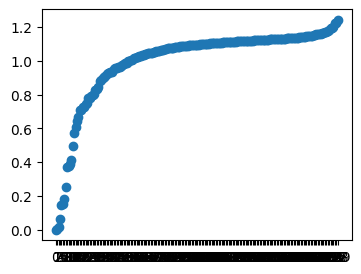

In [26]:
# Plotting the eigenvalues
plt.rcParams["figure.figsize"] = (4,3)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

In [27]:
# Gaps in eigenvalues
gaps = np.diff(e)
eigen_gap_df = pd.DataFrame({'Index': range(len(e) - 1), 'Gap': gaps})
eigen_gap_df.sort_values(by='Gap', ascending=False, inplace=True)

In [28]:
eigen_gap_df

,Index,Gap
7,7,1.213289e-01
11,11,8.720370e-02
3,3,8.199862e-02
12,12,7.802965e-02
6,6,6.660777e-02
...,...,...
178,178,9.650206e-05
135,135,9.013678e-05
170,170,3.709311e-05
150,150,2.055114e-05


In [29]:
eigen_gap_df[eigen_gap_df['Index'] < 10]

,Index,Gap
7,7,0.121329
3,3,0.081999
6,6,0.066608
2,2,0.049620
5,5,0.029477
9,9,0.015934
1,1,0.011619
4,4,0.009755
0,0,0.002232
8,8,0.002184


In [30]:
# Eigen features for k
k = 4
X = v[:, -1*k:]
# row_sums = X.sum(axis=1)
# Y = X / row_sums[:, np.newaxis]

## Clustering

In [31]:
cluster_df = pd.DataFrame(X)
cluster_df

,0,1,2,3
0,-0.000381,0.000007,-0.000002,-1.040375e-13
1,0.000188,0.000026,-0.000009,1.227004e-13
2,-0.001103,-0.000050,0.000019,1.701881e-12
3,-0.000583,-0.000534,0.000173,6.244058e-12
4,-0.006413,0.000008,-0.000002,5.786834e-13
...,...,...,...,...
195,-0.000117,0.000762,-0.000341,2.735937e-10
196,-0.000046,0.014753,-0.005985,-2.151934e-09
197,0.001540,-0.001189,0.000461,8.601757e-11
198,0.000222,-0.001621,-0.001460,1.631281e-07


In [32]:
clustering = KMeans(n_clusters = 4)
clustering.fit(cluster_df)

cluster_labels = clustering.labels_
print(silhouette_score(data_df, cluster_labels),adjusted_rand_score(labels, cluster_labels))

C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


-0.25825766249188736 3.555548262123223e-05


In [ ]:
def spectral_clustering(dataframe, labels, similarity_graph, laplacian, number_of_clusters):

    # Pairwise distances
    dimension = dataframe.shape[0]
    dist_ = pdist(dataframe)
    dist_mat = np.zeros([dimension, dimension])
    dist = iter(dist_)
    for i in range(dimension):
        for j in range(i+1, dimension):  
            d = next(dist)
            dist_mat[i,j] = d
            dist_mat[j,i] = d